# Lab: Alzheimer MRI Model  (Mohamed I.K & Mounim A. E.Y)

#### This notebook is inspired from [this link](https://www.kaggle.com/amyjang/alzheimer-mri-model-tensorflow-2-3-data-loading/notebook)

# Introduction

Machine learning has a phenomenal range of application in the health sciences. This tutorial will go over the complete pipeline to build a model that can determine the dementia level of an Alzheimer's patient from their MRI image.

This tutorial highlights the ease of building a CNN using `tf.keras`. Additionally, TensorFlow 2.3 (or over) has new features, including easy data loading utilities that were previously not available in TensorFlow 2.2. We'll be seeing how easy data loading is with these additional features.

We'll be using a GPU accelerator for this NB.

**This notebook includes the following main steps:**

1. Upload data to colab (`.zip file`) 
2. Import librairies 
3. Data loading
3. Visualize data
4. Feature Engineering
5. Build the ML Model
6. Training the Model
7. Visualize Model Metrics
8. Model Evaluation 

**1. Upload data to colab (.zip file)**

First, Upload manually to data file `Alzheimer_sDataset.zip` to colab.

In [ ]:
# importing required modules
from zipfile import ZipFile
  
# specifying the zip file name
file_name = "/content/Alzheimer_sDataset.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
    # extracting all the files
    zip.extractall()
    print('Done!')

**2. Data Upload**

In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
#from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
import PIL


Automatically, detect the platform of execution (CPU, GPU)


In [ ]:
### https://www.tensorflow.org/guide/distributed_training
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
AUTOTUNE = tf.data.experimental.AUTOTUNE 
print(tf.__version__)

Number of replicas: 1
2.6.0


It's always a good idea to set constant variables instead of hard coding numbers into your code. It saves time later when you want to change certain parameters.

In [ ]:
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [176, 208]

**2. Data Loading**

We'll be using a [Kaggle Alzheimer's dataset](https://www.kaggle.com/tourist55/alzheimers-dataset-4-class-of-images) for our tutorial. `tf.keras` has a new preprocessing function that can easily load in images for a directory. In order for this function to work, the data has to be structured in a file directory format.

```
main_directory/
    class1/
        class1_images
    class2/
        class2_images
```

If you input the `main_directory` into the `tf.keras` function, it will figure out the rest!
In our case, the `train` directory is our main directory.

We are also specifying a 80:20 split for our training and validation datasets. To learn more about the importance of having a validation split, check out this [lesson](https://developers.google.com/machine-learning/crash-course/validation/another-partition) from Google's Machine Learning Crash Course.

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/train",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

Found 5121 files belonging to 4 classes.
Using 4097 files for training.
Found 5121 files belonging to 4 classes.
Using 1024 files for validation.


We'll be renaming the class names and specifying the number of classes. In this case, we have 4 classes of dementia.

In [ ]:
class_names = ['MildDementia', 'ModerateDementia', 'NonDementia', 'VeryMildDementia']
train_ds.class_names = class_names
val_ds.class_names = class_names

NUM_CLASSES = len(class_names)

**4. Visualize the data**

Now that our data has been easily loaded in, the next step is to visualize our images. This helps us understand what is being used as an input for our model. It also serves as a check to see if our images have been loaded in correctly.

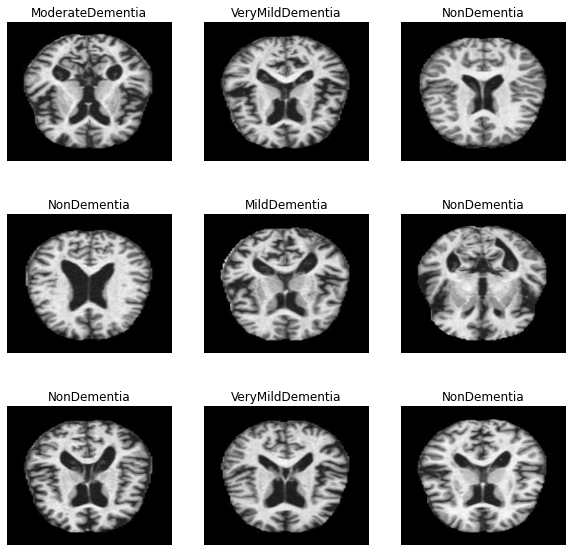

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(train_ds.class_names[labels[i]])
    plt.axis("off")

**5. Feature Engineering**

Because we are working with categorical and noncontinuous data, we want to convert our model into one-hot encodings. One-hot encodings are a way for the model to understand that we're looking at categorial instead of continuous data. Transforming features so that they'll be more understandable is called feature engineering.

In [ ]:
def one_hot_label(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

train_ds = train_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)

The following cell makes calling images from our dataset more efficient.

In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**6. Dataset statistics**

The most conventional metric to use is probably accuracy. Accuracy, however, cannot be used for imbalanced datasets. Let's check how many images are in each class for our training data.

In [ ]:
NUM_IMAGES = []

for label in class_names:
    dir_name = "Alzheimer_s Dataset/train/" + label[:-2] + 'ed'
    NUM_IMAGES.append(len([name for name in os.listdir(dir_name)]))

In [ ]:
NUM_IMAGES

[717, 52, 2560, 1792]

Our dataset is not balanced, so we cannot use accuracy as our metric. For this tutorial, we will be using ROC AUC. Intuitively, ROC AUC gives a score, with higher scores closer to 1 indicating that the different classes can be distinguishable for the model. A lower score closer indicates that the the model cannot distinguish between different classes. A score of 0.5 indicates that the ordering the images is pretty much random. Learn more about ROC AUC [here](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

**7. Build the ML Model**

We'll be using the same architecture for our model as my [Pneumonia Classification NB](https://www.kaggle.com/amyjang/tensorflow-pneumonia-classification-on-x-rays#4.-Build-the-CNN). Using `tf.keras`, we can easily build up the layers of our CNN.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

In [ ]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(*IMAGE_SIZE, 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
    
    return model

In [ ]:
with strategy.scope():
    model = build_model()

    METRICS = [tf.keras.metrics.AUC(name='auc')]
    
    model.compile(
        optimizer='adam',
        loss=tf.losses.CategoricalCrossentropy(),
        metrics=METRICS
    )

**8. Training the Model**

To more efficiently train our model. We will be using callbacks to adjust our learning rate and to stop our model once it converges.

The [learning rate](https://developers.google.com/machine-learning/glossary#learning-rate) is a very important hyperparameter in the model. Having a LR that is too high will prevent the model from converging. Having a LR that is too slow will make the process too long. Stopping our model early is one mechanism that prevents overfitting.

In [25]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("alzheimer_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                     restore_best_weights=True)

Let's fit our model!

In [26]:
EPOCHS = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler],
    epochs=EPOCHS
)

Epoch 1/20
257/257 [==============================] - 64s 115ms/step - loss: 1.1115 - auc: 0.7733 - val_loss: 2.4725 - val_auc: 0.7340
Epoch 2/20
257/257 [==============================] - 27s 105ms/step - loss: 0.9796 - auc: 0.8093 - val_loss: 1.0499 - val_auc: 0.7822
Epoch 3/20
257/257 [==============================] - 27s 106ms/step - loss: 0.9577 - auc: 0.8198 - val_loss: 1.9137 - val_auc: 0.7707
Epoch 4/20
257/257 [==============================] - 27s 106ms/step - loss: 0.9440 - auc: 0.8277 - val_loss: 1.9299 - val_auc: 0.7655
Epoch 5/20
257/257 [==============================] - 27s 106ms/step - loss: 0.9548 - auc: 0.8282 - val_loss: 1.0432 - val_auc: 0.7667
Epoch 6/20
257/257 [==============================] - 27s 106ms/step - loss: 0.9276 - auc: 0.8346 - val_loss: 0.9427 - val_auc: 0.8311
Epoch 7/20
257/257 [==============================] - 27s 105ms/step - loss: 0.9116 - auc: 0.8409 - val_loss: 1.3365 - val_auc: 0.6531
Epoch 8/20
257/257 [==============================] - 2

**9. Visualize Model Metrics**

Let's graph the ROC AUC metric and loss after each epoch for the training and validation data. Although we didn't use a random seed for our notebook, the results may slightly vary, generally the scores for the validataion data is similar, if not better, than the training dataset.

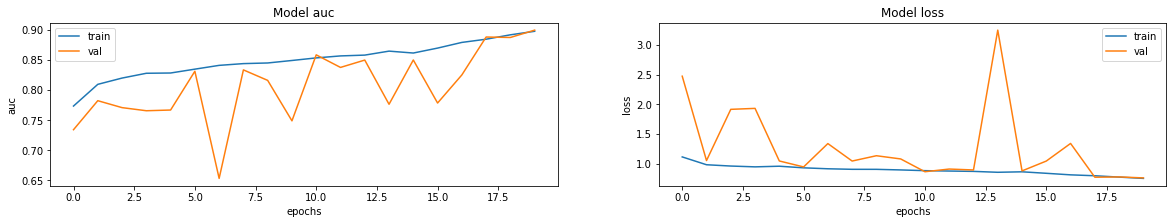

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

**10. Evaluate the Model**

Although we used the validatation dataset to continually evaluate the model, we also have a separate testing dataset. Let's prepare the testing dataset.

In [28]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "Alzheimer_s Dataset/test",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
)

test_ds = test_ds.map(one_hot_label, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 1279 files belonging to 4 classes.


In [29]:
_ = model.evaluate(test_ds)

80/80 [==============================] - 3s 30ms/step - loss: 0.9335 - auc: 0.8484


In [30]:
# Print the performance in terms of AUC
_

[0.933506965637207, 0.8483693599700928]

In [37]:
#predictions = np.argmax(model.predict(test_ds),axis=1)
#labels=[]
#for x, y in test_ds:
#  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])
#  np.sum(predictions==labels)
#  labels.shape

**11 Evaluate a pretrained Model**

Upload manually the `alzheimer_model.h5` to colab

In [42]:
pretrained_model = tf.keras.models.load_model('pretrained_alzheimer_model.h5')
__ = model.evaluate(test_ds)

80/80 [==============================] - 2s 27ms/step - loss: 0.9335 - auc: 0.8484


In [43]:
__

[0.933506965637207, 0.8483693599700928]